# 3 Exploratory Data Analysis<a id='3_Exploratory_Data_Analysis'></a>

## 3.1 Preface<a id='3.1_Preface'></a>

In this notebook we start by closely following the article "The Search for Categorical Correlation" by Shaked Zychlinski: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9. Then we create a bunch of histograms of mushroom class against the other categorical features and one-hot encode those features we find most relevant.

## 3.2 Introduction<a id='3.2_Introduction'></a>

At this point, we have a firm idea of what our data science problem is and have the data we believe could help solve it. The business problem was a general one of modeling mushroom class. The data we started with contained class data for all mushrooms. However, there was an obvious issue with one of the other features in the data that led to one column being completely dropped.

The data science problem we subsequently identified is to predict the class (`e` for edible or `p` for poisonous) of mushrooms.

## 3.3 Imports<a id='3.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from library.sb_utils import save_file

## 3.4 Load The Data<a id='3.4_Load_The_Data'></a>

### 3.4.1 Ski data<a id='3.4.1_Ski_data'></a>

In [2]:
mushroom_data = pd.read_csv('../data/mushroom_data_cleaned.csv')

In [3]:
mushroom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [4]:
mushroom_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


### 3.5.5 Mushroom Categorical Data<a id='3.5.5_Mushroom_Categorical_Data'></a>

#### 3.5.5.2 Feature correlation heatmap<a id='3.5.5.2_Feature_correlation_heatmap'></a>

A great way to gain a high level view of relationships amongst the features is to make a feature correlation heatmap. First we do one-hot encoding on the whole mushroom dataset, but it turns out that gives us 112 binary variables, which for practical purposes is way too many. The feature correlation heatmap using Pearson's r is too complicated and does not give useful information:

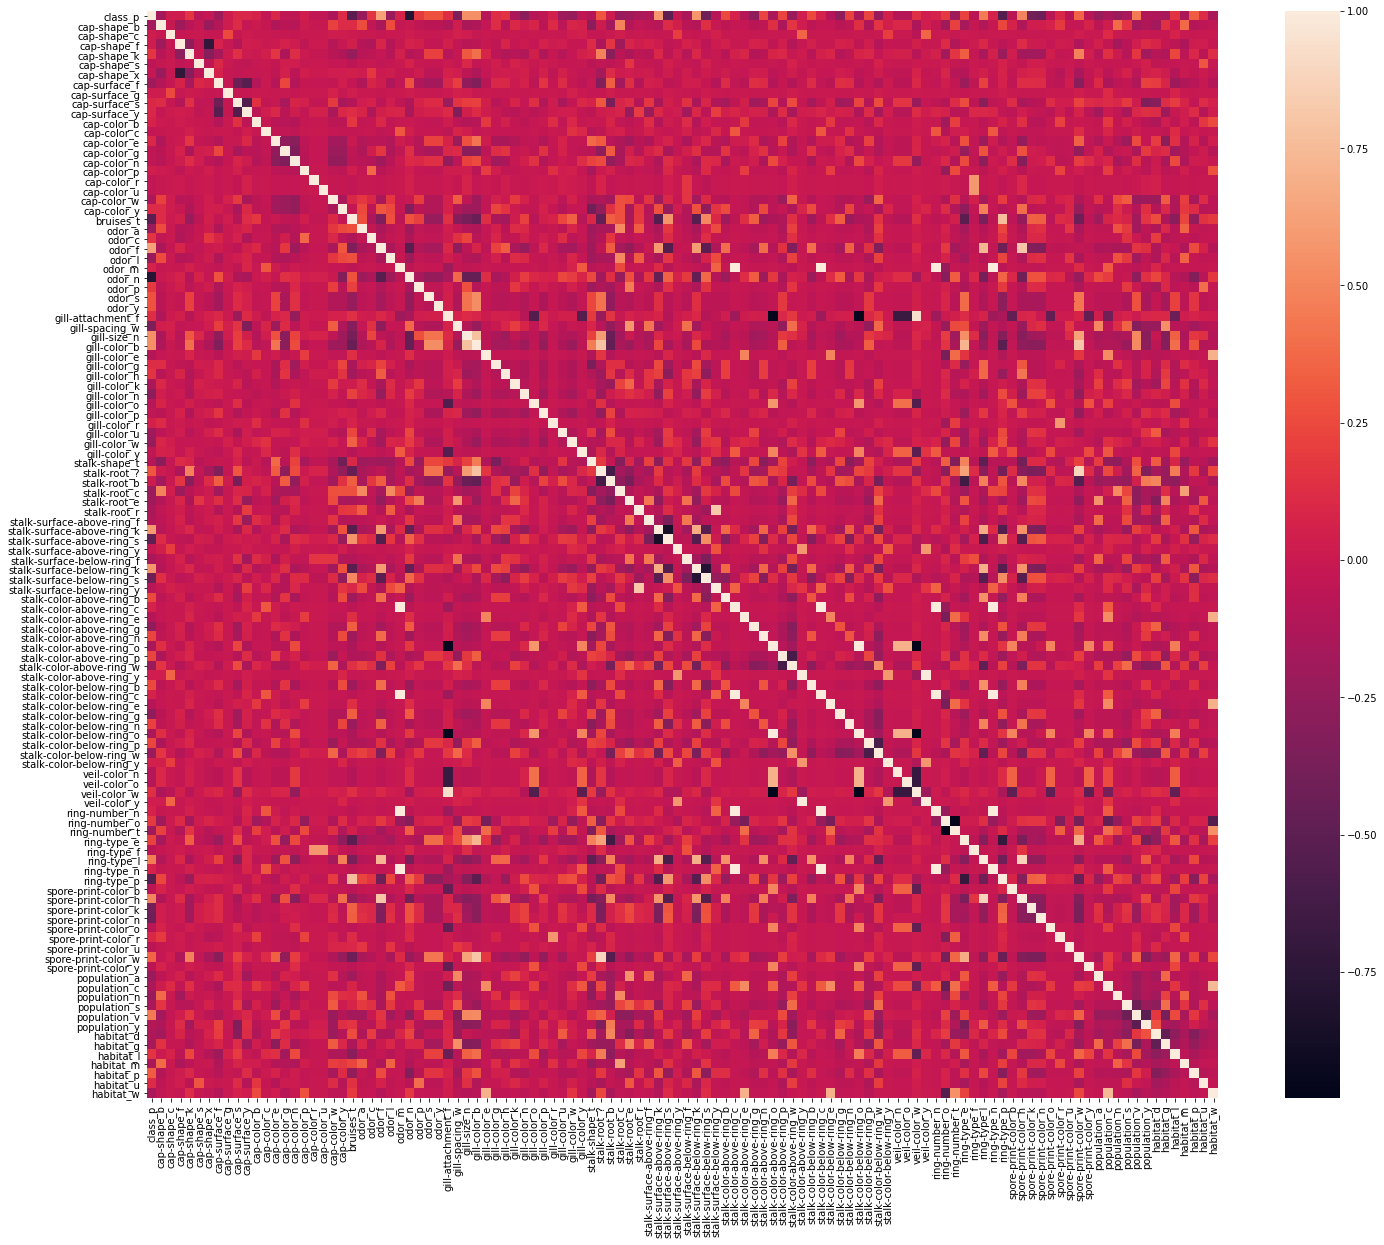

In [5]:
enc = OneHotEncoder(drop='if_binary')
arr = enc.fit_transform(mushroom_data).toarray()
one_hot_all = pd.DataFrame(arr, columns=enc.get_feature_names(mushroom_data.columns))
plt.subplots(figsize=(24,20))
sns.heatmap(one_hot_all.corr(),xticklabels=1,yticklabels=1);

In [6]:
one_hot_all.shape

(8124, 112)

One-hot encoding the entire dataset gives us 112 binary variables, which for practical purposes is way too many. The feature correlation heatmap using Pearson's r is too complicated and does not give useful information. Maybe instead it might make sense to use Cramer's V to get an idea of which categorical variables have the highest magnitude correlation with class. It works with categorical data without the need to one-hot encode everything.

In [7]:
def corr_matrix(data, func):
    arr = np.empty((len(data.T),len(data.T)))
    for i in range(len(data.T)):
        for j in range(len(data.T)):
            arr[i][j] = func(data.iloc[:,i], data.iloc[:,j])
    df = pd.DataFrame(data=arr)
    df.index = data.columns
    df.columns = data.columns
    return df

In [8]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

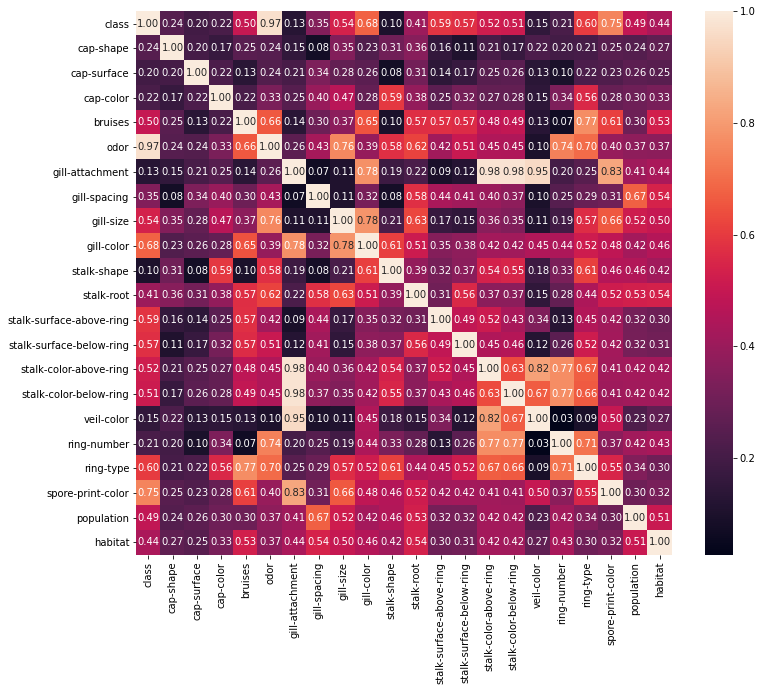

In [9]:
#Show a seaborn heatmap of correlation magnitudes in mushroom_data using Cramer's V.
#Hint: call corr_matrix on `mushroom_data` and pass that into `sns.heatmap`
plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix(data=mushroom_data,func=cramers_v),annot=True,fmt='.2f');

A problem with Cramer's V and other symmetrical measures of correlation is that they don't acknowledge that correlations can be stronger in one direction than the other. For example, being a raven strongly correlates with being black, but being black doesn't as strongly correlate with being a raven because many other black things are not ravens. This is addressed by Theil's U, which makes use of the concept of conditional entropy:

In [10]:
def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * np.log(p_y / p_xy)
    return entropy

In [11]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

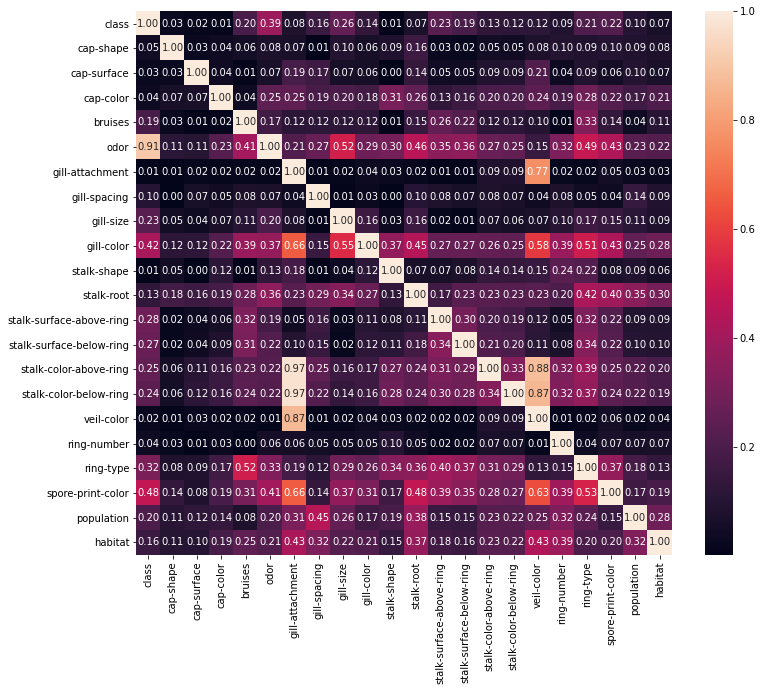

In [12]:
#Show a seaborn heatmap of correlation magnitudes in mushroom_data using Theil's U.
#Theil's U, U(x,y), conditions on y, which in our case would be the column, but
#a transition matrix format ($p_{i,j}$) is more intuitive and conditions on i,
#the row, so we take the transpose of the correlation matrix determined by Theil's U.
#Hint: call corr_matrix on `mushroom_data` and pass that into `sns.heatmap`
plt.subplots(figsize=(12,10))
sns.heatmap(corr_matrix(data=mushroom_data,func=theils_u).T,annot=True,fmt='.2f');

There is a lot to take away from this. Odor has the strongest magnitude correlation with class, and vice versa, but not to nearly the same degree in the other direction. Other features that to a large magnitude correlate with class (>25%) are, in order of importance, spore print color, gill color, ring type, and stalk surface above and below the ring.

#### 3.5.5.3 Histograms of other categorical features against class<a id='3.5.5.3_Histograms_of_other_categorical_features_against_class'></a>

Correlations, particularly viewing them together as a heatmap, can be a great first pass at identifying patterns. But correlation can mask relationships between two variables. You'll now create a series of histograms to really dive into how class varies with other categorical features.

In [13]:
# define useful function to create histograms of mushroom class against desired columns
def histograms(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.hist([mushroom_data[mushroom_data['class']=='e'][col],mushroom_data[mushroom_data['class']=='p'][col]],
                label=['edible','poisonous'],color=['green','red'])
        ax.set(xlabel=col, ylabel='number of species')
        ax.legend()
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [14]:
#Code task 13#
#Use a list comprehension to build a list of features from the columns of `mushroom_data` that
#are _not_ 'class'
features = [f for f in mushroom_data.columns if f not in ['class']]

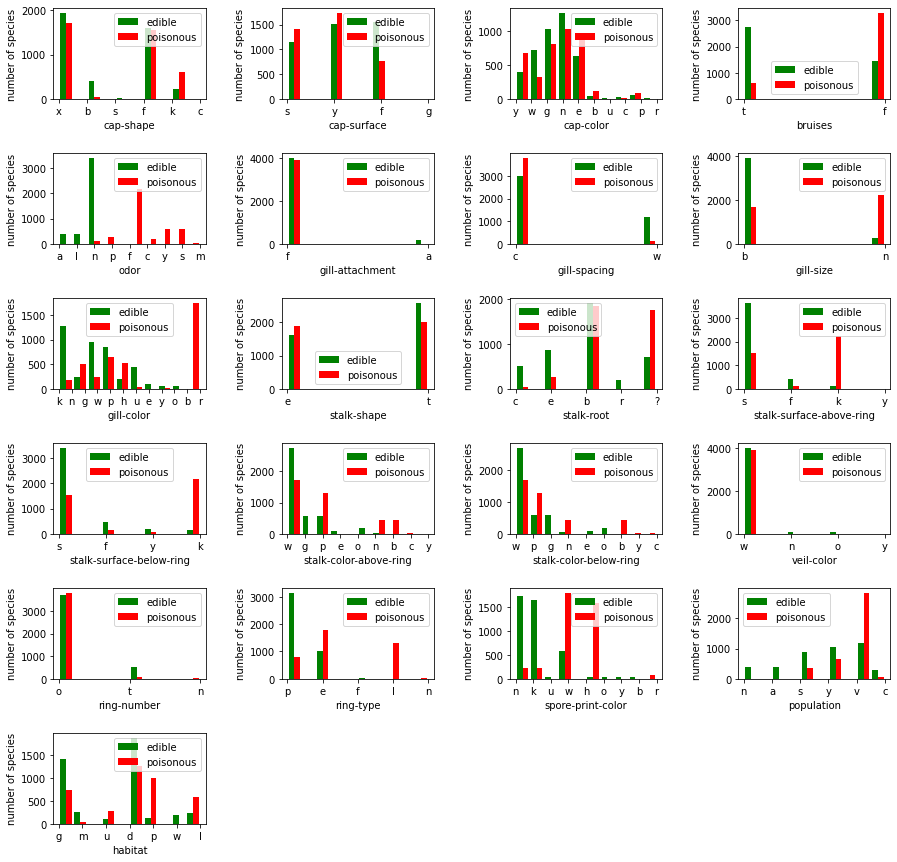

In [15]:
histograms(features, ncol=4, figsize=(15, 15))

In the histograms you see what some of the high magnitude correlations we're clearly picking up on. There's a strong magnitude of correlation with `odor`. `spore-print-color` and `gill-color` seem very useful. `ring-type` also appears useful. `stalk-surface-above-ring` and `stalk-surface-below-ring` show something interesting that you don't see from just a headline correlation figure. It's not a clear picture, although we have some interesting signs. Even `veil-color` which has a correlation of magnitude 0.02 looks like it would give useful binary variables when one-hot encoded. We keep all of the features for now and plan to do dimensionality reduction later.

## 3.6 Summary<a id='3.6_Summary'></a>

**A: 1** We started by closely following the article "The Search for Categorical Correlation" by Shaked Zychlinski: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9. Then we created a bunch of histograms of mushroom class against the other categorical features and one-hot encoded all of the features, planning to do dimensionality reduction later.

In [16]:
one_hot_all.head()

,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Save the data 

datapath = '../data'
save_file(one_hot_all, 'mushroom_data_step3_features.csv', datapath)

Writing file.  "../data/mushroom_data_step3_features.csv"
